In [5]:
from __future__ import print_function
import pyaudio
import pydub
import wave
import numpy as np
import sys
import time
import IPython.display as ipd
from six.moves import xrange
from array import array
import os
import scipy.signal as sg
import matplotlib.pyplot as plt
from scipy.io import wavfile

#
s_t = time.time()
fname = './start.wav'
fs, x = wavfile.read(fname)
x = array('h', x)
e_t = time.time()
print(fs, x[4594],  len(x), type(x[0]))
a = x
print((e_t - s_t)*1000)

#
s_t = time.time()
f = wave.open(fname, 'r')
nf = f.getnframes()
x = f.readframes(nf)
x = array('h', x)
e_t = time.time()
#print(nf, x, type(x), len(x))
#print(x)
b = x
print((e_t - s_t)*1000)
print('SELECTED')

In [40]:

np.sum(a == b)

17616

TypeError: 'getset_descriptor' object is not callable

In [282]:
def add_silence(d_for_silence, d_len = 16000, dtype = 'h'):
    len_ =   len(d_for_silence)
    #print('adding silence to data of len: ', len_,'expected: ',d_len,' and type: ', type(d_for_silence[0]))
    len_diff = d_len - len_
    s = d_for_silence[0]
    e = d_for_silence[-1]
    if len_diff > 0:
        
        pad = (len_diff//2 ) + 1
        pad_list1 = [s for i in xrange(pad)]
        pad_list2 = [e for i in xrange(pad)]
        r = array(dtype, pad_list1)
        r.extend(d_for_silence)
        r.extend(pad_list2)
    else:
        r = d_for_silence
    return r[:d_len]

In [283]:
def get_clean_data(d_for_clean, d_len = 16000, l_filter = False, ff_filter = True,
                   return_numpy = True):
    #print('Adding Silence: ', d_for_clean[0], d_for_clean[-1])
    d_with_silence = add_silence(d_for_clean, d_len)
    
    if l_filter == True:
        s_time = time.time()
        b, a = sg.butter(N=3,Wn= (2 * 300/16000.0,2 * 3400/16000.0 ), btype='bandpass' )
        data_bl = sg.lfilter(a=a, b = b, x = d_with_silence)
        e_time = time.time()
        #print('for lfilter band pass: ', (e_time - s_time) * 1000, type(data_bl[0]))
        d_with_silence = data_bl
    if ff_filter == True:
        s_time = time.time()
        b, a = sg.butter(N=3,Wn= (2 * 300/16000.0,2 * 3400/16000.0 ), btype='bandpass' )
        data_bf = sg.filtfilt(a=a, b = b, x = d_with_silence)
        e_time = time.time()
        #print('for filtfilt band pass: ', (e_time - s_time) * 1000, type(data_bf[0]))
        d_with_silence = data_bf
    if return_numpy == True:
        return np.array(d_with_silence, dtype = type(d_with_silence[0]))
    else:
        return array('d', d_with_silence)

In [284]:
def get_word(fp, silence_buffer, silence_th_ = 1300, frame_size = 1024, n_silence_ = 6):
    is_silence_ = False
    rec = silence_buffer
    rms = []
    nf = 0
    ns = 0
    while not is_silence_:
        sound_data_ = array('h', fp.readframes(frame_size))
        if len(sound_data_) < 1024:
            #print('Exiting as length of sound data is : ', len(sound_data_))
            sound_data_ = array('h', [0 for i in range(1024)])
            
        is_silence_ = max(sound_data_) < silence_th_
        print('is_silent_: ', is_silence_)
        rec.extend(sound_data_)
        rms.append(int(np.sqrt(np.mean(np.array(sound_data_, dtype = np.int64) ** 2))))
        nf += 1
        
    try:    
        rms_np  = np.array(rms, dtype = type(rms[0]))
    except:
        rms_np = 0
    #print(rms_np.sum(),'\t', rms_np.mean(),'\t', nf,'\t', nf > 1)
    
    return rec, int(np.sum(rms)), nf , sound_data_

h
<class 'float'>


Text(0.5, 1.0, 'max: 3940.71 min: -4558.43 mean: -0.00038550320459110684')

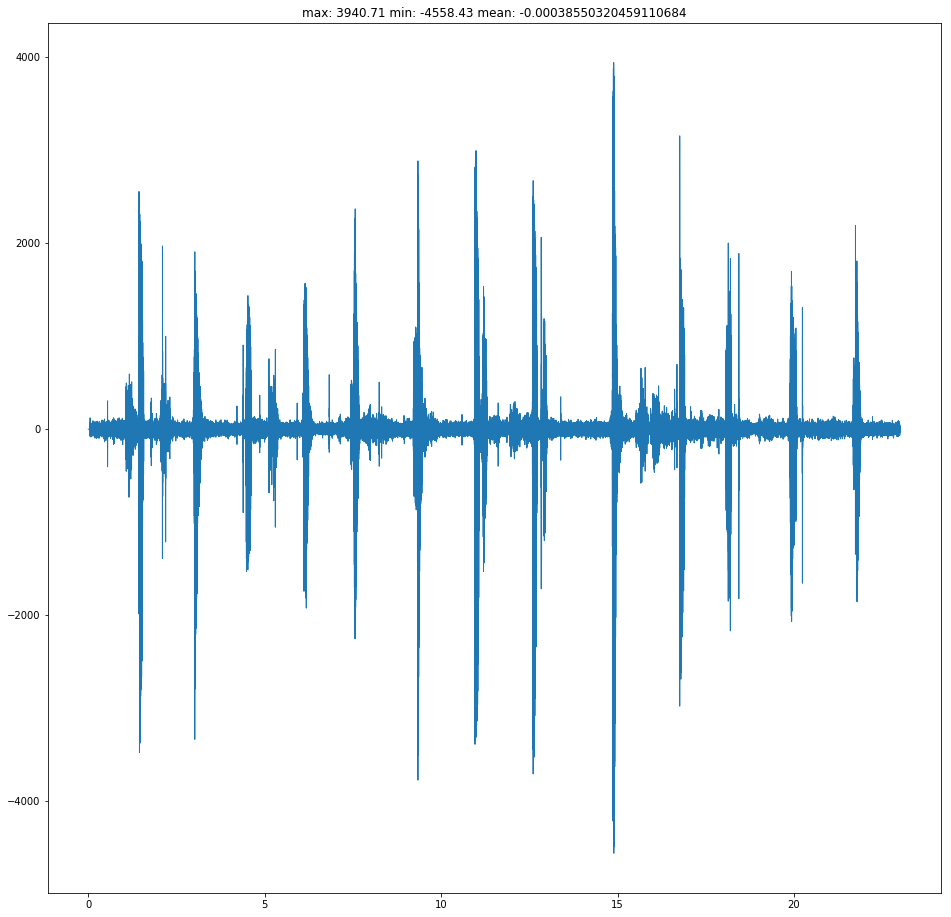

In [285]:
fname = './nidhi_5.wav'
fp = wave.open(fname)
nf = fp.getnframes()
fr = 16000
#print(int(fr))
sound_data_check = array('h', fp.readframes(nf))
print(sound_data_check.typecode)
d = get_clean_data(sound_data_check, d_len = (len(sound_data_check)),
                   return_numpy=False)
print(type(d[0]))
fig, ax = plt.subplots(1, 1,  figsize = (16, 16))
t = np.linspace(0., len(d)//fr, len(d))
title = 'max: '+ str(np.round(max(d), 2))+ ' min: ' +str(np.round(min(d), 2)) + ' mean: '+ str(np.mean(d))
ax.plot(t, d, lw = 1)
ax.set_title(label = title)

In [185]:
ipd.display(ipd.Audio(d, rate = fr, autoplay=True))


In [293]:
def get_words_from_file(fname):
#fname = './Sam_1.wav'
    #fp = wave.open(fname)
    #nf = fp.getnframes()
    frame_size = 1024
    #s_b1 = array('h')
    silence_th_ = 300
    rec_flag = False
    words = []

    with wave.open(fname,) as fp:
        nf = fp.getnframes()
        #print('Number of Frames are: ', nf)

        #sb_1 = get_clean_data(array('h', fp.readframes(frame_size)), d_len = frame_size,
         #                     return_numpy = False)
        #sb_2 = get_clean_data(array('h', fp.readframes(frame_size)), d_len = frame_size,
         #                     return_numpy = False)
        sb_1, sb_2 = array('d'), array('d')
        #print('sb_1, sb_2', type(sb_1), type(sb_2), type(sb_1[0]))
        #if nf <= 2 * frame_size:
         #   raise ValueError('Too Short File or Too Big Frame Size: '+str(frame_size))
        #for i in range(int(2*frame_size), nf, frame_size):
        for i in range(0, nf, frame_size):
            n_silence_ = 0
            #print('Reading Frame: ', i//frame_size)

            arr_ = array('h',fp.readframes(frame_size))
            if len(arr_) < frame_size:
                break
            sound_data_ = get_clean_data(arr_, 
                                         d_len = frame_size,
                                      return_numpy = False)

            is_silent_ = max(sound_data_) < silence_th_
            if is_silent_:
                #print('This is Silent')
                sb_1 = sb_2
                sb_2 = sound_data_
                continue

            #print('len current frame: ', len(sound_data_), max(sound_data_), is_silent_)
            sb_1.extend(sb_2)
            word = sb_1
            word.extend(sound_data_)
            n_f = 0

            while not is_silent_ and i < nf:


                arr_ = array('h',fp.readframes(frame_size))
                if len(arr_) < frame_size:
                    break
                sound_data_1 = get_clean_data(arr_, 
                                         d_len = frame_size,
                                         return_numpy = False)
                word.extend(sound_data_1)
                i += frame_size


                is_silent_1 = max(sound_data_1) < silence_th_

                if is_silent_1 and i < nf:
                    arr_ = array('h',fp.readframes(frame_size))
                    if len(arr_) < frame_size:
                        break
                    sound_data_2 = get_clean_data(arr_, 
                                         d_len = frame_size,
                                      return_numpy = False)
                    i += frame_size

                    is_silent_2 = max(arr_) < silence_th_

                    if is_silent_2:
                        sb_1 = sound_data_1
                        sb_2 = sound_data_2
                        break
                    else:
                        word.extend(sound_data_2)
                        continue

                #print('current frame: ', len(sound_data_), len(word), max(sound_data_), is_silent_)
                n_f += 1
            if n_f > 1:
                words.append(word)
            #print()


            """
            if len(sound_data_) < frame_size:
                break



            if is_silent_:
                sb1 = sound_data_
                continue

            while not rec_flag or n_silence_ <=  6 and i < nf:
                rec_data, rms_, n_f, s_b1 = get_word(fp,
                                                          s_b1,
                                                          silence_th_,
                                                          frame_size = frame_size)
                rec_flag = n_f < 2
                i += n_f
                print(len(rec_data), rms_, rec_flag, len(s_b1), n_silence_)
                print()
                if rec_flag == False:
                    n_silence_ += 1
                else:
                    n_silence_ = 0
            rec_flag = False
            words.append(rec_data)
            """
    print('NUmber of words: ', len(words))
    return words


In [294]:
def get_rms(arr):
    rms = int(np.sqrt(np.mean(np.array(arr, dtype = type(arr[0])) ** 2)))
    return rms

In [301]:
fname = './Sam_5.wav'
words = get_words_from_file(fname)
wanted_n_words = 13
if len(words) < wanted_n_words:
    raise ValueError('Reclear Wav File')
extra_words = len(words) - wanted_n_words
rms_list = np.array([get_rms(w) for w in words])
print('rms_list: ', rms_list)
idxs = np.sort(np.argsort(rms_list)[extra_words:])
print(idxs)
new_words = [words[i] for i in idxs]
#del words[idxs]
print('len new words:', len(idxs))
for word in new_words:
    time.sleep(1)
    s_ = ipd.Audio(word, rate = 16000, autoplay=True)
    print('n_words: ',len(words),'len: ', len(word), ' max: ', max(word), 'rms: ', get_rms(word))
    ipd.display(s_)
    time.sleep(2)
    ipd.clear_output(wait=True)
    

n_words:  14 len:  8192  max:  4313.557739649892 rms:  739
